In [2]:
import matplotlib.pyplot as plt
import pydicom
from splitter_of_mice.splitter import SoM
import numpy as np
import copy
from skimage.transform import rescale
import glob
import os

In [2]:
dicom_dirs = [
    "./sample-data/dicom/mpet3967b_em1_v1.pet",
    "./sample-data/dicom/mpet3967b_ct1_v1.ct",
]

output_dirs = [
    "./output/mpet3967b_em1_v1.pet_split",
    "./output/mpet3967b_ct1_v1.ct_split",
]

splitters = [SoM(dicom_dir, dicom=True) for dicom_dir in dicom_dirs]

# resort splitters by image size, smallest to largest, and also sort their output directories)
(splitters, output_dirs) = zip(*sorted(zip(splitters, output_dirs), key=lambda x: x[0].pi.img_data.shape[0] * x[0].pi.img_data.shape[1]))
splitters = list(splitters)
output_dirs = list(output_dirs)


image_shapes = [(splitter.pi.get_shape('x'), splitter.pi.get_shape('y')) for splitter in splitters]
image_scales = [(image_shape[0] / image_shapes[0][0], image_shape[1] / image_shapes[0][1]) for image_shape in image_shapes]

SoM.desc_map = {'l': 'l', 'r': 'r', 'ctr': 'ctr', 'lb': 'lb', 'rb': 'rb', 'lt': 'lt', 'rt': 'rt'}

In [3]:
# get the cuts from the first splitter and apply them to all the other splitters
splitter_0 = splitters[0]
splitter_0.split_mice(None, num_anim=2, margin=2)
cuts = splitter_0.cuts
for i, (splitter, image_scale) in enumerate(zip(splitters, image_scales)):
    if i == 0:
        continue
    
    splitter.pi.clean_cuts()
    
    # copy the cuts from the first splitter
    scaled_cuts = copy.deepcopy(cuts)
    
    # rescale cuts
    for cut in scaled_cuts:
        cut['rect'].rescale(image_scale[0], image_scale[1])
        
    splitter.cuts = scaled_cuts
    
    # rescale blob_labels, rounding to nearest integer, and setting potential negative values to 0
    rescaled = np.round(rescale(splitter_0.blob_labels, int(image_scale[0]), int(image_scale[1])))
    rescaled[rescaled < 0] = 0
    splitter.blob_labels = rescaled
    
    SoM.add_cuts_to_image(splitter.pi, scaled_cuts, splitter.desc_map, None)

In [4]:
# save the images
for i, (splitter, output_dir) in enumerate(zip(splitters, output_dirs)):
    SoM.write_images(splitter.pi, output_dir)

In [5]:
# save qc_images
for i, (splitter, output_dir) in enumerate(zip(splitters, output_dirs)):
    SoM.qc_image(splitter.pi, splitter.blob_labels, splitter.cuts, output_dir, SoM.desc_map)

/Users/andrewl/anaconda3/envs/mpet-splitter/lib/python3.10/site-packages/skimage/color/colorlabel.py:128: UserWarning: Negative intensities in `image` are not supported
  rgb = _label2rgb_overlay(label, image, colors, alpha, bg_label,


In [6]:
import os
import glob
import numpy as np

def load_image_from_dir(directory):
    # Get all the .dcm files in the filepath
    dicom_files = glob.glob(os.path.join(directory, '*.dcm'))

    # Sort dicom files by InstanceNumber
    dicom_files.sort(key=lambda x: pydicom.dcmread(x).InstanceNumber)

    # Load each image file into a single ndarray
    img_data = np.stack([pydicom.dcmread(dicom_file).pixel_array for dicom_file in dicom_files])
    img_data = img_data[..., np.newaxis]
    return dicom_files, img_data

def plot_dicom_series(directory, rows=5, cols=5, invert=False):
    
    # Load dicom files from directory and sort by InstanceNumber
    dicom_files, img_data = load_image_from_dir(directory)

    num_scans = min(rows * cols, len(dicom_files))

    # Calculate the figure size dynamically based on rows and columns
    figsize = (cols * 3, rows * 3)

    # Create subplots
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.01, hspace=0.01)  # Adjust subplot spacing

    # Plot the images
    for i, j in zip(range(num_scans), np.linspace(0, len(dicom_files) - 1, num=num_scans)):
        ds = pydicom.dcmread(dicom_files[int(j)])

        image = ds.pixel_array
        if invert:
            image = np.max(image) - image  # Invert the image

        row = i // cols
        col = i % cols

        axs[row, col].imshow(image, cmap=plt.cm.gray)
        axs[row, col].axis('off')  # Hide axis labels and ticks

    plt.show()

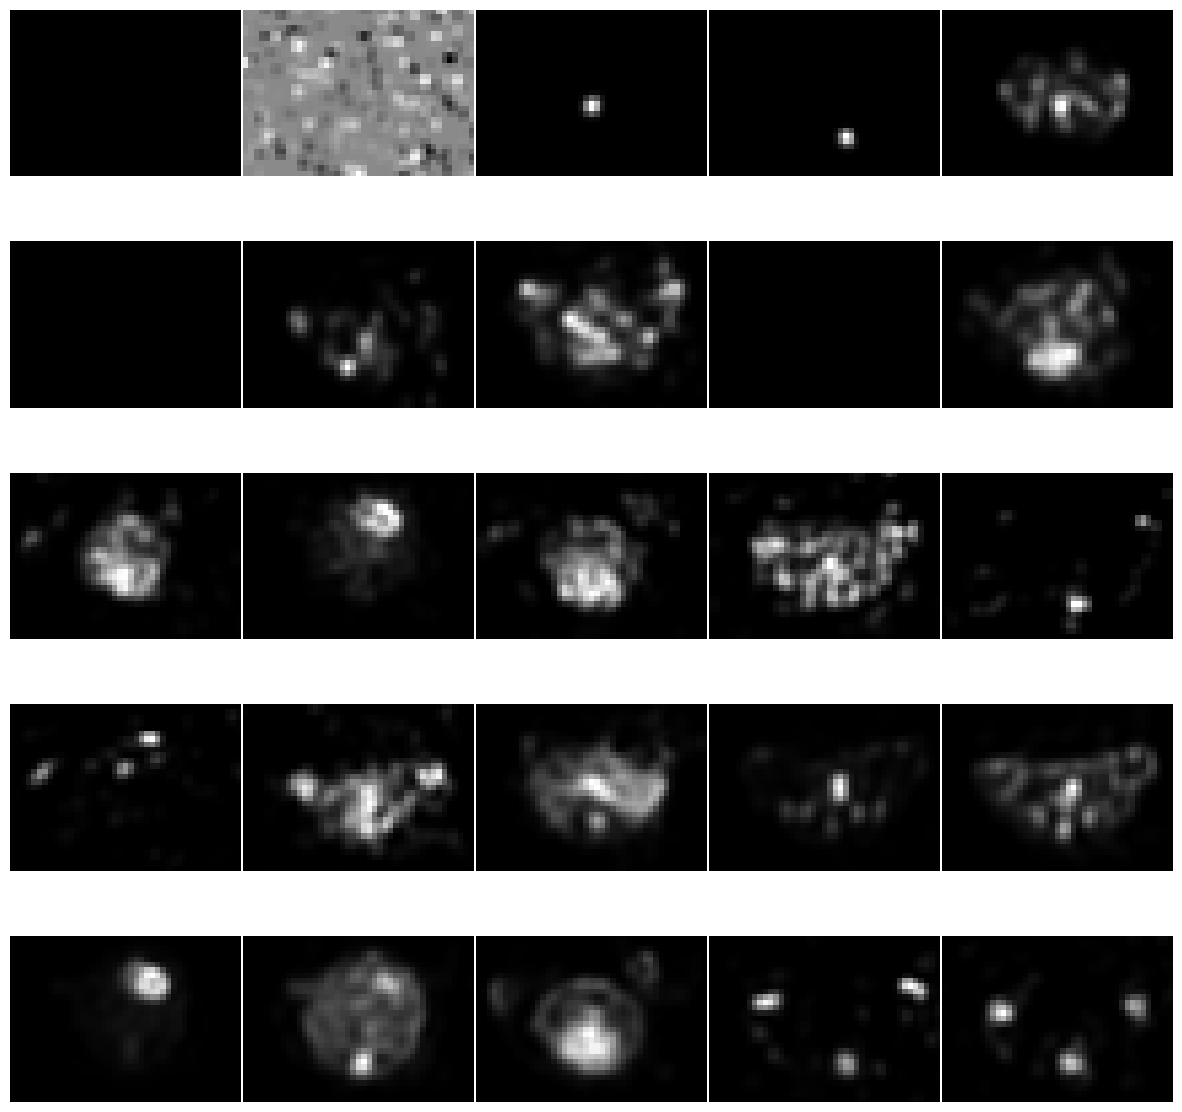

In [7]:
plot_dicom_series('/Users/andrewl/git/andylassiter/ccdb-micropet-hotel-splitter/splitter_of_mice/output/mpet3967b_em1_v1.pet_split/0')  

In [10]:
pydicom.FileDataset('/Users/andrewl/git/andylassiter/ccdb-micropet-hotel-splitter/splitter_of_mice/output/mpet3967b_em1_v1.pet_split/0')

TypeError: FileDataset.__init__() missing 1 required positional argument: 'dataset'

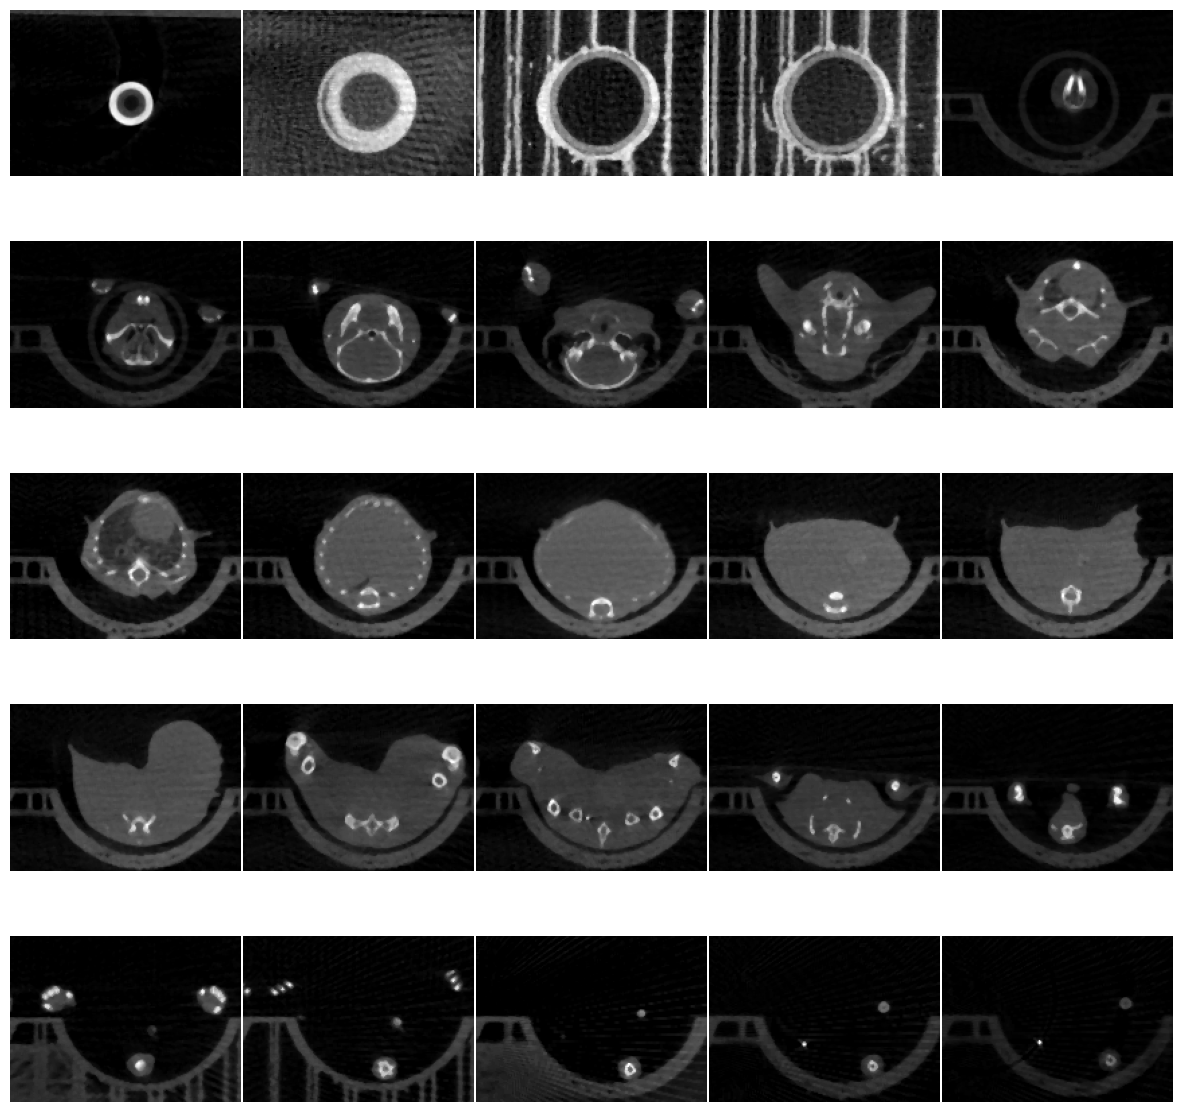

In [8]:
plot_dicom_images('/Users/andrewl/git/andylassiter/ccdb-micropet-hotel-splitter/splitter_of_mice/output/mpet3967b_ct1_v1.ct_split/1')

In [31]:
## Get unique subdirectories containing dicom files
dicom_files = glob.glob('./sample-data/dicom/nscan1404a//**//*.dcm', recursive=True)
dicom = dict([(os.path.dirname(dicom_file), []) for dicom_file in dicom_files])
for dicom_file in dicom_files:
    dicom[os.path.dirname(dicom_file)].append(os.path.basename(dicom_file))
    
dicom_dirs = set([os.path.dirname(dicom_file) for dicom_file in dicom_files])

## For each directory, get the shape of the first image in the directory, doesnt need to be the first image in the directory, just any image
image_shapes = []



In [32]:
dicom_dirs

{'./sample-data/dicom/nscan1404a/3/DICOM',
 './sample-data/dicom/nscan1404a/5/DICOM'}

In [33]:
dicom

{'./sample-data/dicom/nscan1404a/3/DICOM': ['1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-122-iv6b0w.dcm',
  '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-198-1o4v3k4.dcm',
  '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-161-1ki4sq2.dcm',
  '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-669-ys2dgb.dcm',
  '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-693-26i12z.dcm',
  '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-32-11j47uw.dcm',
  '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-268-1b20bzv.dcm',
  '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-640-c6tx0h.dcm',
  '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-404-j1y8tx.dcm',
  '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-537-z3j28c.dcm',
  '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-13-1h6du83.dcm',
  '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-18-198f4om.d

In [34]:
from collections import defaultdict

In [40]:
dicom_files = defaultdict(list)

for dicom_file in glob.glob(f'./sample-data/dicom/nscan1404a/**/*.dcm', recursive=True):
    dicom_files[os.path.dirname(dicom_file)].append(os.path.basename(dicom_file))

In [41]:
dicom_files

defaultdict(list,
            {'./sample-data/dicom/nscan1404a/3/DICOM': ['1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-122-iv6b0w.dcm',
              '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-198-1o4v3k4.dcm',
              '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-161-1ki4sq2.dcm',
              '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-669-ys2dgb.dcm',
              '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-693-26i12z.dcm',
              '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-32-11j47uw.dcm',
              '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-268-1b20bzv.dcm',
              '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-640-c6tx0h.dcm',
              '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-404-j1y8tx.dcm',
              '1.3.6.1.4.1.12842.1.1.14.3.20231122.111414.997.1767866253-3-537-z3j28c.dcm',
              '1.

In [37]:
dicom_files.keys()

dict_keys(['./sample-data/dicom/nscan1404a/3/DICOM', './sample-data/dicom/nscan1404a/5/DICOM'])

In [38]:
defaultdict()

defaultdict(None, {})